# Exercise 04 ANN for Regression - Assignment

<span style="color:red">**The submission deadline of this assignment is 09/04/2024 23:59. In addition to the executed Jupyter Notebook, please also submit the saved `.pth` file of the trained ANN on Learn.**</span>

## Pedagogy

This notebook contains both theoretical explanations and executable cells to execute your code.

When you see the <span style="color:red">**[TBC]**</span> (To Be Completed) sign, it means that you need to perform an action else besides executing the cells of code that already exist. These actions can be:
- Complete the code with proper comments
- Respond to a question
- Write an analysis
- etc.

## Requirement

In this assignment, you are required to build a regression model using ANN.

The problem to be solved is predicting the price of houses in California.

<span style="color:red">**[TBC]**</span> Please complete the following tasks:
- Build the data pipeline
- Create a non-linear multi-layer ANN
- Train the ANN
- Save and load the trained model
- Make predictions and evaluation

### Import libraries

In [1]:
# [TBC] complete your code here with proper comments
# import the necessary libraries
import warnings

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# [TBC] complete your code here with proper comments
# suppress all warnings
warnings.filterwarnings("ignore")

## Task 1. Build the data pipeline

<span style="color:red">**[TBC]**</span> You need to:
- Use `sklearn.datasets.fetch_california_housing()` to load California Housing dataset
- Pre-process the dataset
    - Scale numerical features with [min-max scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- Divide the dataset into the training and test set
- Create `TensorDataset` instances to store the dataset
- Create `DataLoader` instance to wrap the dataset as iterable objects
    - Decide a proper batch size considering
        - The available memory of your computer
        - The desired number of batches in each epoch

In [3]:
# [TBC] complete your code here with proper comments
from sklearn.datasets import fetch_california_housing
# Load the dataset
data = fetch_california_housing(as_frame=True)
features = data.data
labels = data.target


In [4]:
# Scale the numerical features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)



In [5]:
# Train Test split
train_features, test_features, train_labels, test_labels = train_test_split(
    features_scaled, labels, train_size=0.7, random_state=42, shuffle=True)


In [6]:
# Convert numpy arrays to torch tensors
train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32),
                              torch.tensor(train_labels.to_numpy(), dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32),
                             torch.tensor(test_labels.to_numpy(), dtype=torch.float32))


In [7]:
# Create DataLoader instances
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [8]:
# Example: Iterate over the train_loader and print the shapes of features and labels
for X, y in train_loader:
    print("Features batch shape:", X.shape)
    print("Labels batch shape:", y.shape)
    break

Features batch shape: torch.Size([16, 8])
Labels batch shape: torch.Size([16])


## Task 2. Create a non-linear multi-layer ANN

<span style="color:red">**[TBC]**</span> You need to:
- Create a custom class to define the structure of the network
- Create an instance of this class as the ANN

In [9]:
# [TBC] complete your code here with proper comments
# define a custom neural network class
class HousePricePredictor(nn.Module):
    def __init__(self):
        super(HousePricePredictor, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.fc1(x))  # Activation function ReLU for non-linearity
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  # No activation function here as we need a linear output for regression
        return x

In [10]:
# Create the model instance
model = HousePricePredictor()

# Check if a GPU is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

HousePricePredictor(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


## Task 3. Train the ANN

<span style="color:red">**[TBC]**</span> You need to:
- Define a `train()` function
- Specify traing hyper-parameters:
    - the loss function
    - the optimizer
    - the learning rate
    - the number of epoches to train
- Train the ANN
    - Adjust the training hyper-parameters if necessary to get a good result
- Plot the loss history of the training process

In [11]:
# [TBC] complete your code here with proper comments
# Define the training function
def train(dataloader, model, loss_fn, optimizer, epochs):
    batch_loss_history = []  # for recording the average loss of a batch
    epoch_loss_history = []  # for recording the average loss of an epoch
    model.train()  # set the model in training mode

    for epoch in range(epochs):  # iterate pre-defined number of epochs
        epoch_loss = 0.0  # initial epoch loss is set to zero

        for X, y in dataloader:  # get a batch of training samples
            X, y = X.to(device), y.to(device)
            pred = model(X).squeeze()  # make predictions, squeeze() reduce `pred` to 1D tensor
            batch_loss = loss_fn(pred, y)  # compute the current batch loss

            optimizer.zero_grad()  # reset the gradients to zero
            batch_loss.backward()  # compute gradients by backpropagation
            optimizer.step()  # update learning parameters according to gradients

            batch_loss_history.append(batch_loss.item())  # record current batch loss
            epoch_loss += batch_loss.item() * X.size(0)  # accumulate batch losses for compute epoch loss

        epoch_loss /= len(dataloader.dataset)  # compute current epoch loss
        epoch_loss_history.append(epoch_loss)  # record current epoch loss
        print(f"Epoch {epoch + 1}: train loss = {epoch_loss:.4f}")  # print log

    return batch_loss_history, epoch_loss_history

In [13]:
import torch.nn.functional as F

# Define the loss function and optimizer
loss_fn = nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 100

# Check device and move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the neural network
batch_loss_history, epoch_loss_history = train(train_loader, model, loss_fn, optimizer, epochs)


Epoch 1: train loss = 0.3278
Epoch 2: train loss = 0.3267
Epoch 3: train loss = 0.3235
Epoch 4: train loss = 0.3236
Epoch 5: train loss = 0.3267
Epoch 6: train loss = 0.3241
Epoch 7: train loss = 0.3250
Epoch 8: train loss = 0.3250
Epoch 9: train loss = 0.3224
Epoch 10: train loss = 0.3269
Epoch 11: train loss = 0.3238
Epoch 12: train loss = 0.3235
Epoch 13: train loss = 0.3238
Epoch 14: train loss = 0.3215
Epoch 15: train loss = 0.3215
Epoch 16: train loss = 0.3216
Epoch 17: train loss = 0.3202
Epoch 18: train loss = 0.3230
Epoch 19: train loss = 0.3209
Epoch 20: train loss = 0.3215
Epoch 21: train loss = 0.3179
Epoch 22: train loss = 0.3189
Epoch 23: train loss = 0.3164
Epoch 24: train loss = 0.3202
Epoch 25: train loss = 0.3216
Epoch 26: train loss = 0.3173
Epoch 27: train loss = 0.3179
Epoch 28: train loss = 0.3184
Epoch 29: train loss = 0.3185
Epoch 30: train loss = 0.3192
Epoch 31: train loss = 0.3174
Epoch 32: train loss = 0.3174
Epoch 33: train loss = 0.3167
Epoch 34: train los

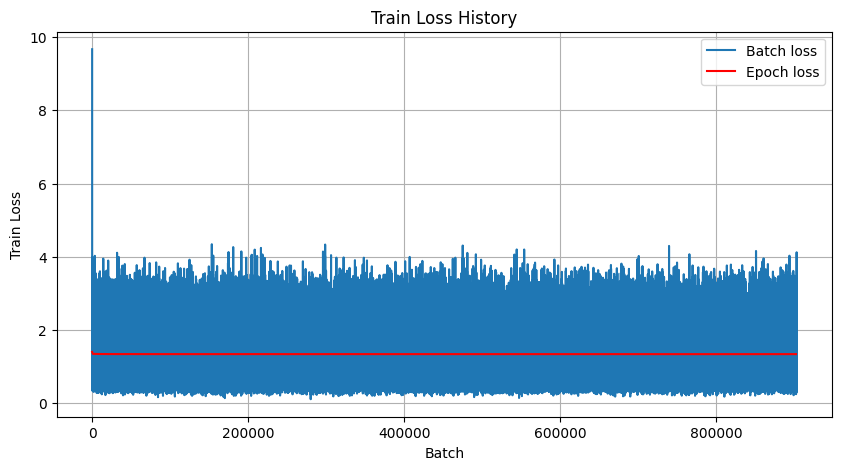

In [ ]:
# Plot the training loss history
plt.figure(figsize=(10, 5))
batch = np.arange(len(batch_loss_history))
epoch = np.arange(len(epoch_loss_history))
batches_per_epoch = len(train_loader)
plt.plot(batch, batch_loss_history, '-', label='Batch loss')
plt.plot(epoch * batches_per_epoch, epoch_loss_history, 'r-', label='Epoch loss')
plt.title('Train Loss History')
plt.xlabel('Batch')
plt.ylabel('Train Loss')
plt.legend()
plt.grid(True)
plt.show()


## Task 4. Save and load the trained model

<span style="color:red">**[TBC]**</span> You need to:
- Save the trained model
    - <span style="color:red">**Don't forget to include the saved file in your submission.**</span>
- Re-create the neural network and load the saved model

In [ ]:
# [TBC] complete your code here with proper comments
# Save model state dictionary
file_name = 'house_price_predictor.pth'
torch.save(model.state_dict(), file_name)
print('Saved PyTorch Model State to ' + file_name)


Saved PyTorch Model State to house_price_predictor.pth


In [ ]:
# Re-create the neural network
model = HousePricePredictor()  # Assuming HousePricePredictor is the class of your model

# Load the saved state dict
model.load_state_dict(torch.load('house_price_predictor.pth'))

# If you need to use the model for inference on CPU
model.to('cpu')
model.eval()  # Set the model to evaluation mode


HousePricePredictor(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

## Task 5. Make predictions and evaluation

<span style="color:red">**[TBC]**</span> You need to:
- Define the `test()` function
- Make predictions on the test dataset
- Evaluate the performance
    - Compute RMSE and print it
    - Compute &R^2& score and print it
- Plot the predictions vs. target values

In [ ]:
# [TBC] complete your code here with proper comments
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def test(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []

    with torch.no_grad():  # No need to track gradients for testing
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            predictions.extend(output.view(-1).tolist())
            actuals.extend(y.view(-1).tolist())

    # Compute RMSE
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)

    print(f'RMSE: {rmse:.4f}')
    print(f'R^2 Score: {r2:.4f}')

    # Plotting predictions vs actuals
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.title('Predictions vs. Actuals')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'k--', lw=4)  # Diagonal line
    plt.show()

    return rmse, r2


RMSE: 1.1027
R^2 Score: 0.0735


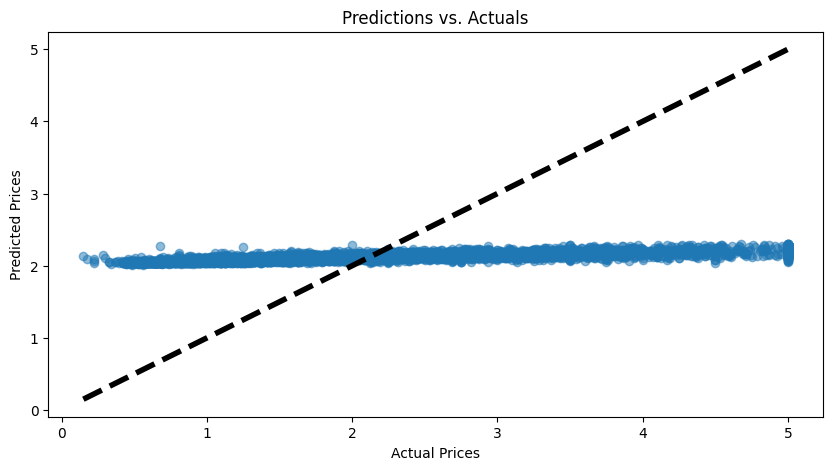

In [ ]:
# Assuming 'device' is defined (either 'cuda' or 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Call the test function
rmse, r2 = test(model, test_loader, device)


In [ ]:
loss_fn = torch.nn.MSELoss()  # Define the loss function as MSE
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False)  d


SyntaxError: invalid syntax (<ipython-input-24-d0071abd8bdc>, line 2)

In [ ]:
test_pred, test_loss = test(test_dl, model, loss_fn)

# Assuming `test_label` is a numpy array or can be extracted from the test dataset
# You might need to collect these from the test DataLoader if not readily available
test_labels = [y for _, y in test_dl]  # Example to extract test labels if not directly available
test_labels = np.concatenate(test_labels)

# Plot the prediction results of the test dataset
plt.figure(figsize=(8, 6))
plt.scatter(test_labels, test_pred, alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'r--')
plt.xlabel('Target Value')
plt.ylabel('Predicted Value')
plt.title('Test Predictions vs. Actual Values')
plt.grid(True)
plt.show()
